Step 1. Build a CaF₂ Cluster with ASE

In [28]:
from ase import Atoms
from ase.build import make_supercell
from ase.io import write
from ase.build import bulk
from ase.cluster import wulff_construction
from ase.io import write

# Build CaF2 fluorite unit cell
caf2 = bulk('CaF2', 'fluorite', a=5.46)  # experimental lattice ~5.46 Å

# Cut out a small cluster (~1 nm) with CaF2 stoichiometry
# (Alternative: just take supercell and slice central atoms)
cluster = caf2.repeat((2,2,2))  # 2x2x2 supercell
cluster.center(vacuum=6.0)

write("caf2_cluster.xyz", cluster)
atoms = read("caf2_cluster.xyz")
print(f"Atoms: {len(atoms)}")
print(f"Formula: {atoms.get_chemical_formula()}")
print(f"Cell dimensions (Å): {atoms.cell.cellpar()}")
print("Cluster with", len(cluster), "atoms written to caf2_cluster.xyz")

Atoms: 24
Formula: Ca8F16
Cell dimensions (Å): [21.45334375 21.45334375 21.45334375 60.         60.         60.        ]
Cluster with 24 atoms written to caf2_cluster.xyz


Step 2. Build a CaF₂:Er Cluster with ASE

In [30]:
from ase.build import bulk
from ase.io import write
import numpy as np

# Step 1: Build CaF2 fluorite cell
caf2 = bulk('CaF2', 'fluorite', a=5.46)

# Step 2: Make a small cluster (supercell with vacuum)
cluster = caf2.repeat((2,2,2))
cluster.center(vacuum=6.0)

# Step 3: Substitute one Ca -> Er to get Ca3:Er ratio in cluster
symbols = cluster.get_chemical_symbols()
ca_indices = [i for i, s in enumerate(symbols) if s == "Ca"]

if len(ca_indices) < 4:
    raise RuntimeError("Not enough Ca atoms to make Ca3:Er substitution!")

# Replace the 4th Ca with Er
symbols[ca_indices[3]] = "Er"
cluster.set_chemical_symbols(symbols)

# Step 4: Save
write("caf2_er_cluster.xyz", cluster)
atoms = read("caf2_er_cluster.xyz")
print(f"Atoms: {len(atoms)}")
print(f"Formula: {atoms.get_chemical_formula()}")
print(f"Cell dimensions (Å): {atoms.cell.cellpar()}")
print("Cluster with", len(cluster), "atoms written to caf2_er_cluster.xyz")

Atoms: 24
Formula: Ca7ErF16
Cell dimensions (Å): [21.45334375 21.45334375 21.45334375 60.         60.         60.        ]
Cluster with 24 atoms written to caf2_er_cluster.xyz


3. Simulate

In [1]:
import os, sys, time, inspect, psutil
# Determine project root (Q-UCSpec) and unified output directory
_project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
OUT_DIR = os.path.join(_project_root, "spectra-results")
os.makedirs(OUT_DIR, exist_ok=True)
# Centralized data directory for all CSV outputs
DATA_DIR = os.path.join(_project_root, "data")
os.makedirs(DATA_DIR, exist_ok=True)
import numpy as np
from ase.io import read, write
from ase.optimize import LBFGS
from gpaw import GPAW, FermiDirac
from gpaw.tddft import TDDFT
from gpaw.mixer import Mixer, MixerSum, MixerDif
from gpaw.poisson import PoissonSolver
from gpaw import GPAW
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from gpaw.lrtddft import LrTDDFT


# --- DeltaKick ---
class DeltaKick:
    def __init__(self, strength=0.001, direction=(1, 0, 0)):
        self._strength = strength
        self.direction = np.array(direction, dtype=float)
        self.applied = False

    def strength(self, time):
        if not self.applied and abs(time) < 1e-8:
            self.applied = True
            return self._strength * self.direction
        return np.zeros(3)


# --- Step 1: Safer LCAO Relax ---
def relax_lcao(xyz_file):
    """
    Relax cluster geometry in LCAO mode with safer SCF settings.
    Uses gentle mixing and looser criteria to improve convergence.
    """
    name = os.path.splitext(xyz_file)[0]
    gpw_lcao = f"{name}_lcao.gpw"

    # Load system
    atoms = read(xyz_file)
    atoms.center(vacuum=10.0)

    # Calculator with cluster-friendly SCF settings
    calc = GPAW(mode="lcao",
                basis="dzp",
                xc="PBE",
                occupations=FermiDirac(0.1),   # slightly larger smearing
                kpts=(1, 1, 1),
                mixer={'backend': 'pulay',
                       'beta': 0.05,    # gentler mixing
                       'nmaxold': 5,    # fewer densities kept
                       'weight': 50.0}, # softer damping
                convergence={'energy': 1e-2, 'density': 1e-2},
                txt=f"{name}_lcao.log")
    atoms.calc = calc

    # Initial SCF to stabilize density before relaxation
    print("Running initial SCF to stabilize density...")
    atoms.get_potential_energy()

    # Geometry optimization (looser fmax first)
    dyn = LBFGS(atoms, logfile=f"{name}_lcao_opt.log")
    dyn.run(fmax=0.15, steps=200)   # relaxed force tolerance

    # Save results
    calc.write(gpw_lcao, mode="all")
    write(f"{name}_lcao_relaxed.xyz", atoms)
    print(f"✔ {name}: saved {gpw_lcao}")
    return gpw_lcao


# --- Step 2: FD Restart---
def groundstate_fd(gpw_lcao, virt_buffer=20, h=0.30):
    name = gpw_lcao.replace("_lcao.gpw", "_fd")
    gpw_fd = f"{name}.gpw"
    if os.path.exists(gpw_fd):
        print(f"Using cached {gpw_fd}")
        return gpw_fd

    lcao_calc = GPAW(gpw_lcao)
    n_occ = int(np.ceil(lcao_calc.get_number_of_electrons() / 2.0))
    n_bands = n_occ + virt_buffer

    calc = GPAW(gpw_lcao,
                mode="fd",
                h=h,
                xc="PBE",
                occupations=FermiDirac(0.03),
                nbands=n_bands,
                poissonsolver=PoissonSolver('fd', eps=1e-12),
                mixer={"beta": 0.05, "nmaxold": 10, "weight": 100},
                convergence={"energy": 3e-4, "density": 2e-4, "eigenstates": 4},
                symmetry={"point_group": False},
                txt=f"{name}.log")
    calc.get_potential_energy()
    calc.write(gpw_fd, mode="all")
    return gpw_fd


#  --- Step 3: TDDFT Runner (Modern GPAW ≥ 25.x) -----
def run_lrtddft(gpw_fd, prefix="system", emax=10.0, sigma=0.1):
    """Linear-Response TDDFT with auto memory and auto state detection."""
    print(f"\n=== Running LrTDDFT on {gpw_fd} ===")
    start_time = time.time()

    calc = GPAW(gpw_fd)
    free_mem_gb = psutil.virtual_memory().available / 1e9
    total_states = len(calc.get_eigenvalues())
    print(f"Available RAM ≈ {free_mem_gb:.2f} GB | KS states = {total_states}")

    # --- Run modern LrTDDFT ---
    try:
        lr = LrTDDFT(calc)
        lr.diagonalize()
        print("TDDFT: modern auto-state solver active.")
    except Exception as e:
        print(f"Fallback legacy solver due to: {e}")
        lr = LrTDDFT(calc)
        lr.diagonalize()

    # --- Extract excitations ---
    energies, osc = [], []
    for exc in lr:
        e = exc.get_energy() * 27.2114  # eV
        f = np.linalg.norm(exc.get_oscillator_strength())
        if e <= emax:
            energies.append(e)
            osc.append(f)
    print(f"Extracted {len(energies)} excitations below {emax:.1f} eV.")

    # --- Save raw data ---
    np.savetxt(os.path.join(DATA_DIR, f"{prefix}_sticks.csv"),
               np.column_stack([energies, osc]),
               delimiter=",", header="Energy(eV),OscStrength", comments="")

    # --- Broaden and plot spectrum ---
    x = np.linspace(0, emax + 0.5, 1000)
    y = np.zeros_like(x)
    for e, f in zip(energies, osc):
        y[np.argmin(np.abs(x - e))] += f
    y_smooth = gaussian_filter1d(y, sigma * 100)

    plt.figure(figsize=(6,4))
    plt.plot(x, y_smooth, label=f"{prefix}")
    plt.scatter(energies, osc, c="red", s=15, label="Excitations")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Oscillator strength (a.u.)")
    plt.legend()
    plt.tight_layout()
    try:
        OUT_DIR
    except NameError:
        _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
        OUT_DIR = os.path.join(_project_root, "spectra-results")
        os.makedirs(OUT_DIR, exist_ok=True)
    plt.savefig(os.path.join(OUT_DIR, f"{prefix}_spectrum.png"), dpi=300)
    plt.close()

    runtime = (time.time() - start_time)/60
    print(f"TDDFT runtime: {runtime:.2f} min | Saved: {os.path.join(OUT_DIR, f'{prefix}_spectrum.png')}\n")

    return os.path.join(DATA_DIR, f"{prefix}_sticks.csv"), os.path.join(OUT_DIR, f"{prefix}_spectrum.png")

# -----------------------------------------------------
#  Main Simulation Pipeline
# -----------------------------------------------------
def run_pipeline(xyz_file):
    prefix = xyz_file.replace(".xyz", "")
    gpw_lcao = f"{prefix}_lcao.gpw"
    gpw_fd   = f"{prefix}_fd.gpw"
    spec_csv = os.path.join(DATA_DIR, f"{prefix}_sticks.csv")
    spec_png = os.path.join(OUT_DIR, f"{prefix}_spectrum.png")

    print(f"\n=== Starting pipeline for {prefix} ===")

    # --- Step 1: Relax geometry (LCAO) ---
    if os.path.exists(gpw_lcao):
        print(f"✔ Cached LCAO found: {gpw_lcao}")
    else:
        print(f"Running LCAO relaxation for {prefix} …")
        gpw_lcao = relax_lcao(xyz_file)

    # --- Step 2: Ground-state FD calculation ---
    if os.path.exists(gpw_fd):
        print(f"✔ Cached FD found: {gpw_fd}")
    else:
        print(f"Running FD ground state for {prefix} …")
        gpw_fd = groundstate_fd(gpw_lcao)

    # --- Step 3: TDDFT spectrum ---
    if os.path.exists(spec_csv):
        print(f"✔ TDDFT already complete — skipping.")
        return spec_csv, spec_png
    else:
        sticks, spectrum = run_lrtddft(gpw_fd, prefix=prefix)
        print(f"TDDFT complete: {sticks}, {spectrum}")
        return sticks, spectrum


spectrum_files = run_pipeline("caf2_cluster.xyz")

# Run on Er-doped cluster
# spectrum_files = run_pipeline("caf2_er_cluster.xyz")


=== Starting pipeline for caf2_cluster ===
✔ Cached LCAO found: caf2_cluster_lcao.gpw
✔ Cached FD found: caf2_cluster_fd.gpw

=== Running LrTDDFT on caf2_cluster_fd.gpw ===
Available RAM ≈ 0.37 GB | KS states = 116

Kohn-Sham single transitions

KSS 2177 transitions (restrict={})
KSS TRK sum 16.3548 (15.838,16.5499,16.6765)
KSS polarisabilities(l=0-3) 16.3548, 3404.6, 2.44916e+07, 6.0256e+11

Linear response TDDFT calculation

RPA 2177 transitions
RPA kss[0]= # <KSSingle> 0->94 0(0) eji=43.7438[eV] (-0.000496737,-0.000496619,-0.000496593)
RPA estimated time left 15h32m44s
RPA kss[1]= # <KSSingle> 0->95 0(0) eji=43.8595[eV] (-7.32332e-05,-6.86547e-05,-6.8336e-05)
RPA estimated time left 13h54m22s
RPA kss[2]= # <KSSingle> 0->96 0(0) eji=43.9328[eV] (-1.89949e-06,-5.96262e-06,7.21282e-06)
RPA estimated time left 12h23m53s
RPA kss[3]= # <KSSingle> 0->97 0(0) eji=43.933[eV] (-9.57075e-06,5.03766e-06,3.87248e-06)
RPA estimated time left 13h18m52s
RPA kss[4]= # <KSSingle> 0->98 0(0) eji=43.9

In [4]:
#!/usr/bin/env python3
"""
Enhanced statistical description for caf2_cluster_sticks.csv
Generates terminal summary + Markdown report with key transition stats.
"""

import os, sys, csv, numpy as np, pandas as pd
try:
    from scipy.stats import skew, kurtosis  # type: ignore
except Exception:
    def skew(a):
        a = np.asarray(a, dtype=float)
        m = np.mean(a)
        s = np.std(a)
        if s == 0:
            return 0.0
        m3 = np.mean(((a - m) / s) ** 3)
        return float(m3)
    def kurtosis(a):
        a = np.asarray(a, dtype=float)
        m = np.mean(a)
        s = np.std(a)
        if s == 0:
            return 0.0
        m4 = np.mean(((a - m) / s) ** 4)
        return float(m4 - 3.0)

# Ensure DATA_DIR is defined for direct cell execution
try:
    DATA_DIR
except NameError:
    _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    DATA_DIR = os.path.join(_project_root, "data")
    os.makedirs(DATA_DIR, exist_ok=True)

FILENAME = os.path.join(DATA_DIR, "caf2_cluster_sticks.csv")
OUTPUT_MD = "caf2_cluster_sticks_summary.md"

# --- Safe load with legacy fallback ---
if not os.path.exists(FILENAME):
    # Try to locate a legacy CSV and copy it into DATA_DIR
    legacy = None
    legacy_candidates = [
        os.path.join(os.getcwd(), "caf2_cluster_sticks.csv"),
        os.path.join(_project_root, "simulations_gpaw", "caf2_cluster_sticks.csv"),
    ]
    for p in legacy_candidates:
        if os.path.exists(p):
            legacy = p
            break
    if legacy:
        print(f"[WARN] Missing data file; using legacy CSV at {legacy} and copying to {FILENAME} …")
        try:
            import shutil
            os.makedirs(os.path.dirname(FILENAME), exist_ok=True)
            shutil.copyfile(legacy, FILENAME)
            print(f"[INFO] Copied legacy CSV into data directory: {FILENAME}")
        except Exception as ce:
            print(f"[WARN] Could not copy legacy CSV into data dir: {ce}")

if not os.path.exists(FILENAME):
    sys.exit(f"[ERROR] File not found: {FILENAME}")

try:
    df = pd.read_csv(FILENAME)
except Exception as e:
    sys.exit(f"[ERROR] Failed to load CSV: {e}")

# --- Flexible column detection ---
colE = [c for c in df.columns if "Energy" in c][0]
colF = [c for c in df.columns if "Osc" in c or "f" in c][0]

E = df[colE].astype(float).to_numpy()
F = df[colF].astype(float).to_numpy()

if E.size == 0 or F.size == 0:
    sys.exit("[ERROR] Empty dataset or unrecognized columns.")

# --- Derived quantities ---
wl = 1240.0 / np.maximum(E, 1e-9)
Σf = F.sum()
E_mean, E_median = E.mean(), np.median(E)
F_mean, F_median = F.mean(), np.median(F)
centroid_E = (E * F).sum() / Σf if Σf > 0 else np.nan
centroid_λ = 1240.0 / max(centroid_E, 1e-6)

# --- Basic statistics ---
stats = {
    "Transitions": len(E),
    "Energy (eV) Range": f"{E.min():.3f} – {E.max():.3f}",
    "Energy Mean / Median": f"{E_mean:.3f} / {E_median:.3f}",
    "Osc. Strength Min / Mean / Median / Max":
        f"{F.min():.3e} / {F_mean:.3e} / {F_median:.3e} / {F.max():.3e}",
    "Σf (Total Osc. Strength)": f"{Σf:.6f}",
    "Centroid Energy (eV)": f"{centroid_E:.3f}",
    "Centroid Wavelength (nm)": f"{centroid_λ:.0f}",
    "Energy Skewness": f"{skew(E):.3f}",
    "Energy Kurtosis": f"{kurtosis(E):.3f}",
}

# --- Display in terminal ---
print("\n=== caf2_cluster_sticks.csv Statistical Summary ===")
for k, v in stats.items():
    print(f"{k:35s}: {v}")

# --- Top 10 strongest transitions ---
idx = np.argsort(F)[-10:][::-1]
top_transitions = [(E[i], wl[i], F[i]) for i in idx]

print("\nTop 10 Transitions (strongest → weakest):")
for n, (e, lam, f) in enumerate(top_transitions, 1):
    print(f"{n:2d}. E = {e:6.3f} eV   λ ≈ {lam:6.0f} nm   f = {f:.3e}")

# --- Markdown report ---
with open(OUTPUT_MD, "w") as f:
    f.write("# CaF₂ Cluster TDDFT Stick Data Summary\n\n")
    f.write("| Metric | Value |\n|:--|:--|\n")
    for k, v in stats.items():
        f.write(f"| {k} | {v} |\n")
    f.write("\n## Top 10 Transitions\n\n")
    f.write("| # | Energy (eV) | Wavelength (nm) | Osc. Strength (f) |\n|:-:|:-:|:-:|:-:|\n")
    for n, (e, lam, fval) in enumerate(top_transitions, 1):
        f.write(f"| {n} | {e:.3f} | {lam:.0f} | {fval:.3e} |\n")


=== caf2_cluster_sticks.csv Statistical Summary ===
Transitions                        : 1120
Energy (eV) Range                  : 0.044 – 9.007
Energy Mean / Median               : 3.662 / 3.438
Osc. Strength Min / Mean / Median / Max: 1.141e-12 / 1.097e-02 / 5.063e-05 / 1.245e+00
Σf (Total Osc. Strength)           : 12.290188
Centroid Energy (eV)               : 4.649
Centroid Wavelength (nm)           : 267
Energy Skewness                    : 0.244
Energy Kurtosis                    : -1.147

Top 10 Transitions (strongest → weakest):
 1. E =  8.192 eV   λ ≈    151 nm   f = 1.245e+00
 2. E =  8.193 eV   λ ≈    151 nm   f = 1.244e+00
 3. E =  2.759 eV   λ ≈    449 nm   f = 6.836e-01
 4. E =  3.051 eV   λ ≈    406 nm   f = 6.593e-01
 5. E =  2.049 eV   λ ≈    605 nm   f = 5.285e-01
 6. E =  2.325 eV   λ ≈    533 nm   f = 4.311e-01
 7. E =  2.222 eV   λ ≈    558 nm   f = 4.002e-01
 8. E =  2.855 eV   λ ≈    434 nm   f = 4.000e-01
 9. E =  2.216 eV   λ ≈    560 nm   f = 3.825e-01
10. E

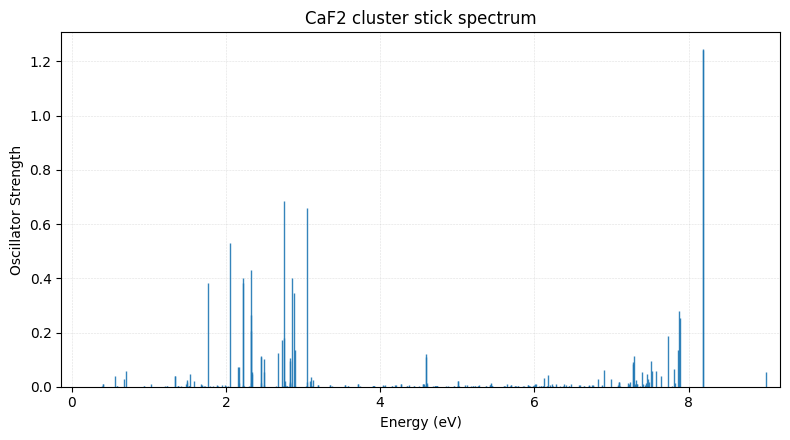

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Prefer pandas if available; fall back to csv
try:
    import pandas as pd
    df = pd.read_csv(os.path.join(DATA_DIR, "caf2_cluster_sticks.csv"))
    cols = {c.lower().strip(): c for c in df.columns}
    energy_col = cols.get('energy(ev)') or cols.get('energy') or list(df.columns)[0]
    osc_col = cols.get('oscstrength') or cols.get('oscillator_strength') or list(df.columns)[1]
    energies = df[energy_col].astype(float).to_numpy()
    strengths = df[osc_col].astype(float).to_numpy()
except Exception:
    import csv
    energies = []
    strengths = []
    with open(os.path.join(DATA_DIR, "caf2_cluster_sticks.csv"), "r", newline="") as f:
        reader = csv.DictReader(f)
        field_map = {k.lower().strip(): k for k in (reader.fieldnames or [])}
        energy_key = field_map.get('energy(ev)') or field_map.get('energy')
        osc_key = field_map.get('oscstrength') or field_map.get('oscillator_strength')
        if energy_key is None or osc_key is None:
            f.seek(0)
            reader2 = csv.reader(f)
            header = next(reader2, None)
            for row in reader2:
                if not row:
                    continue
                energies.append(float(row[0]))
                strengths.append(float(row[1]))
        else:
            for row in reader:
                energies.append(float(row[energy_key]))
                strengths.append(float(row[osc_key]))
    energies = np.array(energies, dtype=float)
    strengths = np.array(strengths, dtype=float)

# Plot sticks
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.vlines(energies, 0, strengths, colors='#1f77b4', linewidth=1.0, alpha=0.9)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Oscillator Strength")
ax.set_title("CaF2 cluster stick spectrum")

# Nice bounds and grid
ax.margins(x=0.02)
ymax = strengths.max() if strengths.size else 1.0
ax.set_ylim(0, ymax * 1.05)
ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)

plt.tight_layout()
try:
    OUT_DIR
except NameError:
    _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    OUT_DIR = os.path.join(_project_root, "spectra-results")
    os.makedirs(OUT_DIR, exist_ok=True)
out_path = os.path.join(OUT_DIR, "caf2_cluster_sticks.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import pandas as pd
import numpy as np

# --- Load the data ---
df = pd.read_csv(os.path.join(DATA_DIR, "caf2_cluster_sticks.csv"))

# --- Identify columns automatically ---
colE = [c for c in df.columns if "Energy" in c][0]
colF = [c for c in df.columns if "Osc" in c or "f" in c][0]

E = df[colE].astype(float).to_numpy()
F = df[colF].astype(float).to_numpy()

# --- Find the index of maximum oscillator strength ---
idx_max = np.argmax(F)
E_max = E[idx_max]
F_max = F[idx_max]
λ_max = 1240.0 / np.maximum(E_max, 1e-9)

# --- Print results ---
print("=== HIGHEST OSCILLATOR STRENGTH TRANSITION ===")
print(f"Index: {idx_max}")
print(f"Energy (eV): {E_max:.3f}")
print(f"Wavelength (nm): {λ_max:.1f}")
print(f"Oscillator Strength (f): {F_max:.6f}")

# --- Optional: save a filtered one-row CSV ---
pd.DataFrame({
    "Energy (eV)": [E_max],
    "Wavelength (nm)": [λ_max],
    "Oscillator Strength (f)": [F_max]
}).to_csv(os.path.join(DATA_DIR, "caf2_cluster_strongest_transition.csv"), index=False)

=== HIGHEST OSCILLATOR STRENGTH TRANSITION ===
Index: 1111
Energy (eV): 8.192
Wavelength (nm): 151.4
Oscillator Strength (f): 1.245125


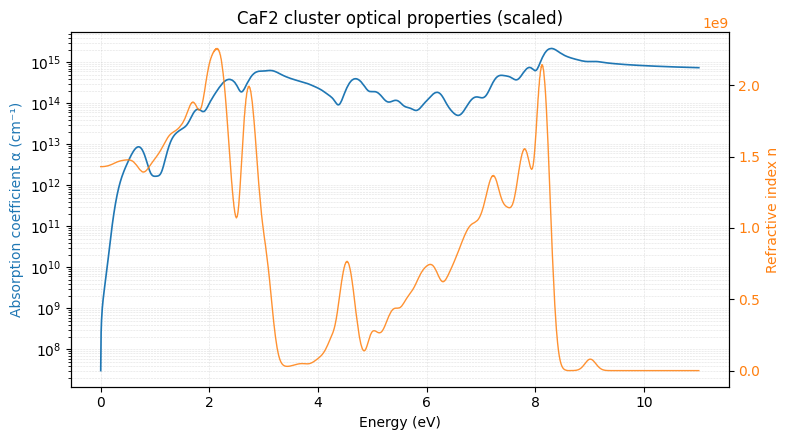

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

csv_path = os.path.join(DATA_DIR, "caf2_cluster_optical_properties_scaled.csv")

# Ensure optical properties CSV exists in DATA_DIR; otherwise, copy from legacy locations
try:
    _project_root
except NameError:
    _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if not os.path.exists(csv_path):
    try:
        import shutil
    except Exception:
        shutil = None
    legacy_candidates = [
        os.path.join(os.getcwd(), "caf2_cluster_optical_properties_scaled.csv"),
        os.path.join(_project_root, "simulations_gpaw", "caf2_cluster_optical_properties_scaled.csv"),
        os.path.join(_project_root, "simulations_gpaw", "CaF Cluster_optical_properties_scaled.csv"),
    ]
    found_legacy = None
    for p in legacy_candidates:
        if os.path.exists(p):
            found_legacy = p
            break
    if found_legacy and shutil is not None:
        try:
            os.makedirs(DATA_DIR, exist_ok=True)
            shutil.copyfile(found_legacy, csv_path)
            print(f"[INFO] Copied legacy optical CSV from {found_legacy} to {csv_path}")
        except Exception as ce:
            print(f"[WARN] Could not copy legacy optical CSV: {ce}")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Optical properties CSV not found: {csv_path}")

# Prefer pandas if available; fall back to csv
try:
    import pandas as pd
    df = pd.read_csv(csv_path)
    cols = {c.lower().strip(): c for c in df.columns}
    e_col = cols.get('energy(ev)') or cols.get('energy') or list(df.columns)[0]

    # Try to find absorption alpha column (scaled)
    alpha_candidates = ['alpha(cm^-1)', 'alpha (cm^-1)', 'alpha', 'absorption']
    alpha_col = None
    for key in alpha_candidates:
        for c in df.columns:
            if c.lower().strip() == key.lower():
                alpha_col = c
                break
        if alpha_col:
            break

    # Optional: refractive index column
    n_candidates = ['n', 'refractive_index', 'refractive index']
    n_col = None
    for key in n_candidates:
        for c in df.columns:
            if c.lower().strip() == key.lower():
                n_col = c
                break
        if n_col:
            break

    E = df[e_col].astype(float).to_numpy()
    alpha = df[alpha_col].astype(float).to_numpy() if alpha_col else None
    nvals = df[n_col].astype(float).to_numpy() if n_col else None
except Exception:
    import csv
    E, alpha, nvals = [], [], []
    with open(csv_path, "r", newline="") as f:
        reader = csv.reader(f)
        header = next(reader, [])
        header_l = [h.lower().strip() for h in header]
        def idx_of(keys):
            for key in keys:
                if key.lower() in header_l:
                    return header_l.index(key.lower())
            return None
        iE = idx_of(['energy(eV)', 'energy', 'e'])
        iA = idx_of(['alpha(cm^-1)', 'alpha (cm^-1)', 'alpha', 'absorption'])
        iN = idx_of(['n', 'refractive_index', 'refractive index'])
        for row in reader:
            if not row:
                continue
            if iE is not None:
                E.append(float(row[iE]))
            if iA is not None:
                alpha.append(float(row[iA]))
            if iN is not None:
                nvals.append(float(row[iN]))
    E = np.array(E, dtype=float)
    alpha = np.array(alpha, dtype=float) if len(alpha) else None
    nvals = np.array(nvals, dtype=float) if len(nvals) else None

# Plot
fig, ax = plt.subplots(figsize=(8, 4.5))

if alpha is not None and np.size(alpha) == np.size(E):
    ax.plot(E, alpha, color='tab:blue', lw=1.2, label='α (cm⁻¹)')
    # α spans orders of magnitude; use log scale for readability
    try:
        ax.set_yscale('log')
    except Exception:
        pass
    ax.set_ylabel('Absorption coefficient α (cm⁻¹)', color='tab:blue')
else:
    ax.plot(E, np.zeros_like(E), alpha=0)
    ax.set_ylabel('Value')

ax.set_xlabel('Energy (eV)')
ax.set_title('CaF2 cluster optical properties (scaled)')
ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)

# Optional secondary axis for refractive index n(E)
if nvals is not None and np.size(nvals) == np.size(E):
    ax2 = ax.twinx()
    ax2.plot(E, nvals, color='tab:orange', lw=1.0, alpha=0.85, label='n')
    ax2.set_ylabel('Refractive index n', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.tight_layout()
try:
    OUT_DIR
except NameError:
    _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    OUT_DIR = os.path.join(_project_root, "spectra-results")
    os.makedirs(OUT_DIR, exist_ok=True)
out_path = os.path.join(OUT_DIR, "caf2_cluster_optical_properties_scaled.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

Using normalization volume = 1.000e-27 m³


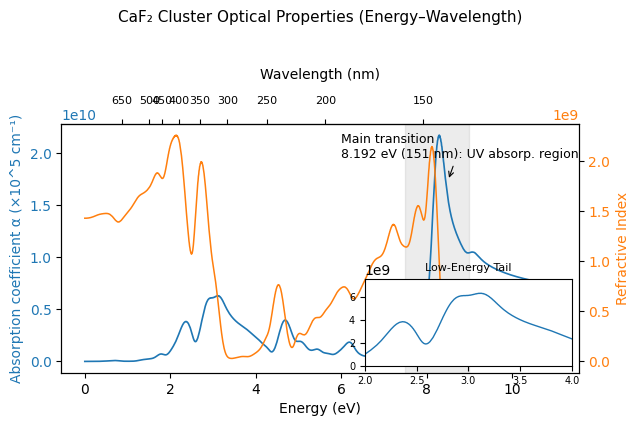

In [17]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Optional dependencies with graceful fallbacks
try:
    from scipy.integrate import simpson as _simpson
except Exception:
    _simpson = None

try:
    from scipy.ndimage import gaussian_filter1d as _gaussian_filter1d
except Exception:
    _gaussian_filter1d = None

try:
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes as _inset_axes
except Exception:
    _inset_axes = None


def _read_sticks_csv(path):
    """Read a TDDFT sticks CSV robustly. Returns (E, f) as float numpy arrays.
    Accepts headers like 'Energy(eV), OscStrength' (case-insensitive) and falls
    back to first two columns if headers unknown.
    """
    # Prefer pandas if available
    try:
        import pandas as pd
        df = pd.read_csv(path)
        cols = {c.lower().strip(): c for c in df.columns}
        e_col = cols.get('energy(eV)'.lower()) or cols.get('energy') or list(df.columns)[0]
        f_col = cols.get('oscstrength') or cols.get('oscillator_strength') or list(df.columns)[1]
        E = df[e_col].astype(float).to_numpy()
        f = df[f_col].astype(float).to_numpy()
        return E, f
    except Exception:
        import csv
        E_list, f_list = [], []
        with open(path, 'r', newline='') as fh:
            # Try DictReader first
            reader = csv.DictReader(fh)
            field_map = {k.lower().strip(): k for k in (reader.fieldnames or [])}
            ek = field_map.get('energy(eV)'.lower()) or field_map.get('energy')
            fk = field_map.get('oscstrength') or field_map.get('oscillator_strength')
            if ek is None or fk is None:
                fh.seek(0)
                rdr = csv.reader(fh)
                _ = next(rdr, None)  # header maybe
                for row in rdr:
                    if not row or len(row) < 2:
                        continue
                    try:
                        E_list.append(float(row[0]))
                        f_list.append(float(row[1]))
                    except Exception:
                        continue
            else:
                for row in reader:
                    try:
                        E_list.append(float(row[ek]))
                        f_list.append(float(row[fk]))
                    except Exception:
                        continue
        return np.asarray(E_list, dtype=float), np.asarray(f_list, dtype=float)


def compute_optical_properties(sticks_csv, prefix="optical", broaden_sigma=0.1, atoms=None):

    # -----------------------------------------------------
    # Load TDDFT stick spectrum
    # -----------------------------------------------------
    if not os.path.isfile(sticks_csv):
        raise FileNotFoundError(f"Sticks CSV not found: {sticks_csv}")
    E_sticks, f_sticks = _read_sticks_csv(sticks_csv)
    if E_sticks.size == 0 or f_sticks.size == 0:
        raise ValueError("No data found in sticks CSV.")

    # Continuous energy grid (avoid zero exactly)
    Emax = float(np.nanmax(E_sticks)) if np.isfinite(E_sticks).any() else 10.0
    x = np.linspace(0.001, max(0.5, Emax) + 2.0, 1500)
    y = np.zeros_like(x)

    # Place sticks on nearest grid index for later smoothing
    idxs = np.searchsorted(x, np.clip(E_sticks, x[0], x[-1]))
    idxs = np.clip(idxs, 0, len(x) - 1)
    np.add.at(y, idxs, f_sticks)

    # Broadening
    if _gaussian_filter1d is not None:
        # approximate mapping from eV sigma to sample sigma
        sample_sigma = max(0.5, broaden_sigma / (x[1] - x[0]))
        y = _gaussian_filter1d(y, sample_sigma)
    else:
        # numpy fallback: convolve with a Gaussian kernel
        dx = x[1] - x[0]
        sample_sigma = max(1.0, broaden_sigma / dx)
        half_width = int(4 * sample_sigma)
        t = np.arange(-half_width, half_width + 1)
        kernel = np.exp(-0.5 * (t / sample_sigma) ** 2)
        kernel /= kernel.sum() if kernel.sum() != 0 else 1.0
        y = np.convolve(y, kernel, mode='same')

    # -----------------------------------------------------
    # Physical constants
    # -----------------------------------------------------
    eV_to_J = 1.602176634e-19
    hbar = 1.054571817e-34
    c = 2.99792458e8
    eps0 = 8.854187817e-12

    # -----------------------------------------------------
    # Volume normalization (m³)
    # -----------------------------------------------------
    if atoms is not None:
        try:
            volume = float(atoms.get_volume()) * (1e-10) ** 3  # Å^3 → m^3
        except Exception:
            volume = (10e-10) ** 3
    else:
        volume = (10e-10) ** 3  # ~1 nm³
    print(f"Using normalization volume = {volume:.3e} m³")

    # -----------------------------------------------------
    # Dielectric function (model based on broadened oscillator strength)
    # -----------------------------------------------------
    eps2 = (2 * np.pi * eV_to_J * y) / (max(volume, 1e-30) * eps0)

    # Kramers–Kronig for eps1
    eps1 = np.empty_like(eps2)
    tiny = 1e-6
    for i, Ei in enumerate(x):
        denom = x**2 - Ei**2
        # Principal-value style: exclude a tiny neighborhood around the singularity
        mask = np.abs(denom) > tiny
        integrand = np.zeros_like(x)
        integrand[mask] = (eps2[mask] * x[mask]) / denom[mask]
        if _simpson is not None:
            val = (2.0 / np.pi) * _simpson(integrand, x=x)
        else:
            val = (2.0 / np.pi) * np.trapz(integrand, x)
        eps1[i] = 1.0 + val
    # Replace any non-finite values in eps1 to prevent propagation
    eps1 = np.nan_to_num(eps1, nan=0.0, posinf=0.0, neginf=0.0)

    # -----------------------------------------------------
    # Optical quantities
    # -----------------------------------------------------
    # Use hypot to avoid overflow/underflow in sqrt(eps1**2 + eps2**2)
    root = np.hypot(eps1, eps2)
    n = np.sqrt(np.maximum(0.5 * (root + eps1), 0.0))
    kappa = np.sqrt(np.maximum(0.5 * (root - eps1), 0.0))
    # Absorption coefficient: α = 2 κ ω / c, with ω = E/ħ; convert m⁻1 → cm⁻1 by /100
    alpha = (2.0 * kappa * (x * eV_to_J) / hbar) / (c * 100.0)  # cm⁻1
    # Ensure downstream quantities are finite
    n = np.nan_to_num(n, nan=0.0, posinf=0.0, neginf=0.0)
    kappa = np.nan_to_num(kappa, nan=0.0, posinf=0.0, neginf=0.0)
    alpha = np.nan_to_num(alpha, nan=0.0, posinf=0.0, neginf=0.0)

    # -----------------------------------------------------
    # Save processed data
    # -----------------------------------------------------
    out_csv = os.path.join(DATA_DIR, f"{prefix}_optical_properties_scaled.csv")
    data = np.column_stack([x, eps1, eps2, n, kappa, alpha])
    header = "Energy(eV),eps1,eps2,n,kappa,alpha(cm^-1)"
    np.savetxt(out_csv, data, delimiter=",", header=header, comments="")

    # -----------------------------------------------------
    # Plot
    # -----------------------------------------------------
    mask = np.isfinite(x) & np.isfinite(alpha) & (x > 0)
    x_valid, alpha_valid, n_valid = x[mask], alpha[mask], n[mask]

    fig, ax1 = plt.subplots(figsize=(6.5, 4.3))
    ax1.plot(x_valid, alpha_valid / 1e5, color='tab:blue', lw=1.2, label='Absorption (×1e5 cm⁻¹)')
    ax1.set_xlabel("Energy (eV)")
    ax1.set_ylabel("Absorption coefficient α (×10^5 cm⁻¹)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Twin axis for refractive index
    ax2 = ax1.twinx()
    ax2.plot(x_valid, n_valid, color='tab:orange', lw=1.1, label='Refractive Index n(E)')
    ax2.set_ylabel("Refractive Index", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Top wavelength axis (inverted: longer lambda at left, shorter at right)
    def ev_to_nm(E):
        return np.clip(1240.0 / np.maximum(E, 1e-3), 100.0, 2000.0)

    def nm_to_ev(lam):
        return np.clip(1240.0 / np.maximum(lam, 1e-3), 0.1, 15.0)

    ax3 = ax1.secondary_xaxis('top', functions=(ev_to_nm, nm_to_ev))
    ax3.set_xlabel("Wavelength (nm)", labelpad=12)
    ax3.tick_params(axis='x', pad=10, labelsize=8, direction='out')

    # Invert so that low energy ↔ long wavelength align physically
    ax3.invert_xaxis()

    def _set_wavelength_ticks_custom():
        E_min, E_max = ax1.get_xlim()
        wl_lo = ev_to_nm(E_max)
        wl_hi = ev_to_nm(E_min)
        lo, hi = (min(wl_lo, wl_hi), max(wl_lo, wl_hi))
        if not np.isfinite(lo) or not np.isfinite(hi) or hi - lo < 1e-6:
            ax3.xaxis.set_major_locator(mticker.FixedLocator([]))
            return
        candidates = np.array([150, 200, 250, 300, 350, 400, 450, 500, 650])
        ticks = candidates[(candidates >= lo) & (candidates <= hi)]
        ax3.xaxis.set_major_locator(mticker.FixedLocator(ticks))
        ax3.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
        ax3.get_xaxis().get_offset_text().set_visible(False)

    def _on_xlim_change(_ax):
        _set_wavelength_ticks_custom()

    ax1.callbacks.connect('xlim_changed', _on_xlim_change)
    _set_wavelength_ticks_custom()

    # Highlight and annotate UV transition
    if x_valid.size:
        yref = max(alpha_valid / 1e5) if np.size(alpha_valid) else 1.0
        ax1.axvspan(7.5, 9.0, color='gray', alpha=0.15, label="UV absorption region")
        ax1.annotate(
            "Main transition\n8.192 eV (151 nm): UV absorp. region",
            xy=(8.5, yref * 0.8),
            xytext=(6.0, yref * 0.9),
            arrowprops=dict(arrowstyle="->", color='black', lw=0.8),
            fontsize=9,
        )

    # Inset (low-energy tail) if inset_axes is available
    if _inset_axes is not None and x_valid.size:
        ax_inset = _inset_axes(ax1, width="40%", height="35%", loc='lower right')
        ax_inset.plot(x_valid, alpha_valid / 1e5, color='tab:blue', lw=1)
        ax_inset.set_xlim(2, 4)
        mask24 = (x_valid > 2) & (x_valid < 4)
        if np.any(mask24):
            ax_inset.set_ylim(0, float(np.max(alpha_valid[mask24] / 1e5)) * 1.2)
        ax_inset.set_title("Low-Energy Tail", fontsize=8)
        ax_inset.tick_params(axis='both', labelsize=7)

    fig.suptitle(f"{prefix} Optical Properties (Energy–Wavelength)", fontsize=11)

    # -----------------------------------------------------
    # suppress warnings
    # -----------------------------------------------------
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

    try:
        OUT_DIR
    except NameError:
        _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
        OUT_DIR = os.path.join(_project_root, "spectra-results")
        os.makedirs(OUT_DIR, exist_ok=True)
    out_fig = os.path.join(OUT_DIR, f"{prefix}_optical.png")
    plt.savefig(out_fig, dpi=500, bbox_inches='tight')
    plt.show()

    return out_csv, out_fig

optical_files = compute_optical_properties(os.path.join(DATA_DIR, "caf2_cluster_sticks.csv"), prefix="CaF₂ Cluster")

[Peak] Strongest transition: 8.192 eV  |  151.4 nm  |  f = 1.245


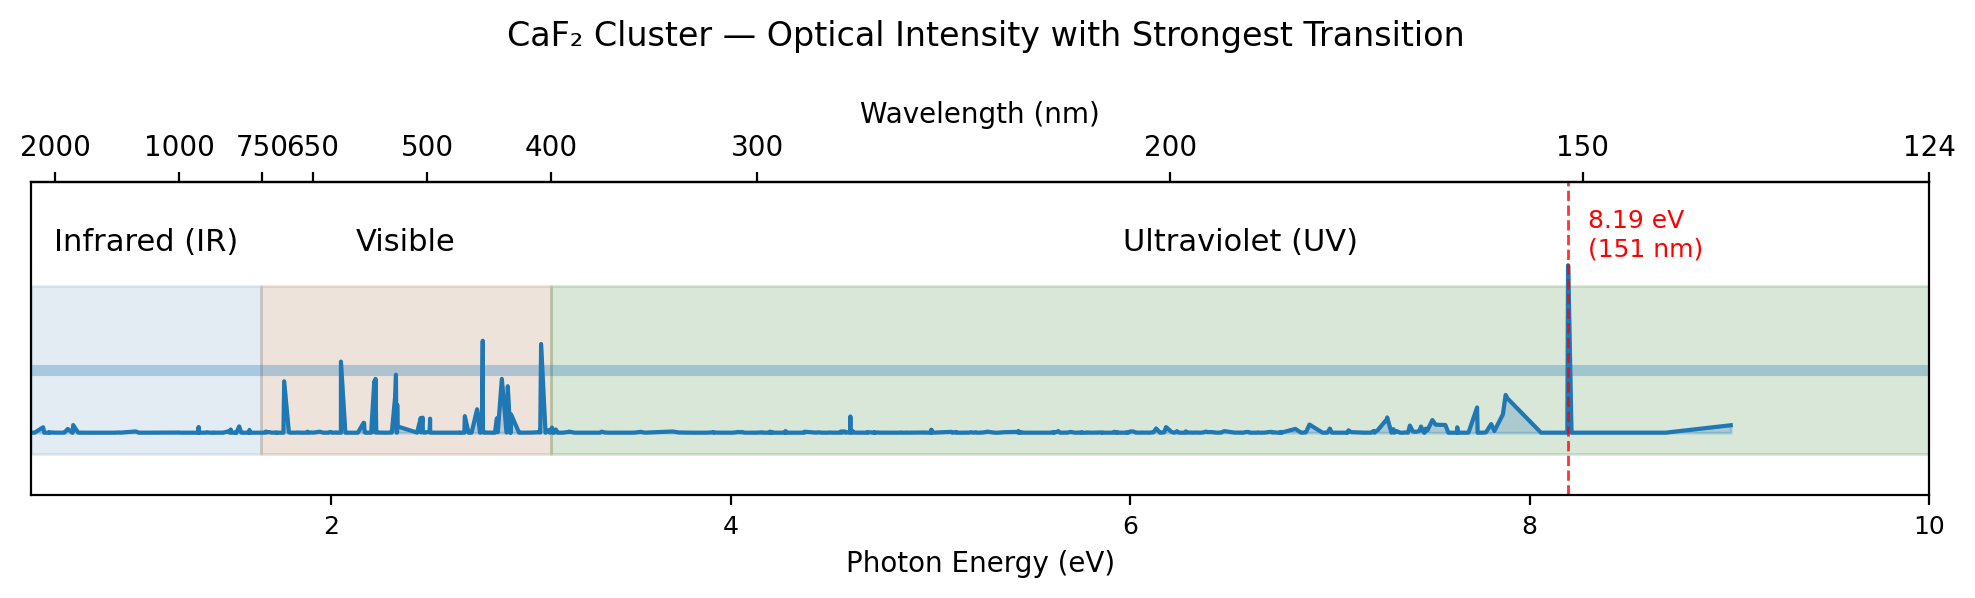

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the data ---
df = pd.read_csv(os.path.join(DATA_DIR, "caf2_cluster_sticks.csv"))
colE = [c for c in df.columns if "Energy" in c][0]
colF = [c for c in df.columns if "Osc" in c or "f" in c][0]

E = df[colE].astype(float).to_numpy()
F = df[colF].astype(float).to_numpy()

# Normalize intensity
intensity = F / np.max(F)

# --- Find strongest transition ---
idx_max = np.argmax(F)
E_max = E[idx_max]
F_max = F[idx_max]
λ_max = 1240.0 / np.maximum(E_max, 1e-9)

print(f"[Peak] Strongest transition: {E_max:.3f} eV  |  {λ_max:.1f} nm  |  f = {F_max:.3f}")

# --- Define EM bands ---
E_min, E_max_plot = 0.5, 10.0
IR_lo, IR_hi = 0.5, 1.65
VIS_lo, VIS_hi = 1.65, 3.10
UV_lo, UV_hi = 3.10, 10.0

fig, ax = plt.subplots(figsize=(10, 3), dpi=200)
ax.hlines(1, E_min, E_max_plot, linewidth=4, alpha=0.3)

def add_band(x0, x1, label, color, alpha=0.15):
    ax.fill_between([x0, x1], [0.8, 0.8], [1.2, 1.2], alpha=alpha, step="mid", color=color)
    ax.text((x0 + x1)/2, 1.27, label, ha='center', va='bottom', fontsize=11)

add_band(IR_lo, IR_hi,  "Infrared (IR)", "steelblue")
add_band(VIS_lo, VIS_hi, "Visible", "#8B4513")
add_band(UV_lo,  UV_hi,  "Ultraviolet (UV)", "darkgreen")

# --- Plot intensity curve ---
scaled_y = 0.4 * intensity + 0.85
ax.plot(E, scaled_y, color='tab:blue', lw=1.5)
ax.fill_between(E, 0.85, scaled_y, color='tab:blue', alpha=0.25)

# --- Highlight the real strongest transition ---
ax.axvline(E[idx_max], color='red', lw=1, ls='--', alpha=0.8)
ax.text(E[idx_max] + 0.1, 1.26,
        f"{E[idx_max]:.2f} eV\n({λ_max:.0f} nm)",
        color='red', fontsize=9, va='bottom')

# --- Axis setup ---
ax.set_xlim(E_min, E_max_plot)
ax.set_ylim(0.7, 1.45)
ax.set_xlabel("Photon Energy (eV)", fontsize=10)
ax.set_yticks([])
ax.tick_params(axis='x', labelsize=9)

# --- Top wavelength axis ---
def E_to_lambda(E): return 1240 / np.maximum(E, 1e-3)
def lambda_to_E(lam): return 1240 / np.maximum(lam, 1e-3)

secax = ax.secondary_xaxis('top', functions=(E_to_lambda, lambda_to_E))
secax.set_xlabel("Wavelength (nm)", fontsize=10)
secax.set_xticks([2000, 1000, 750, 650, 500, 400, 300, 200, 150, 124])
secax.set_xticklabels([str(int(t)) for t in [2000, 1000, 750, 650, 500, 400, 300, 200, 150, 124]])
secax.invert_xaxis()

fig.suptitle("CaF₂ Cluster — Optical Intensity with Strongest Transition", fontsize=12, y=0.98)
plt.tight_layout()
try:
    OUT_DIR
except NameError:
    _project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    OUT_DIR = os.path.join(_project_root, "Q-UCSpec/spectra-results")
    os.makedirs(OUT_DIR, exist_ok=True)
plt.savefig(os.path.join(OUT_DIR, "caf2_cluster_peak.png"), dpi=500, bbox_inches='tight')
plt.show()